In [ ]:
from google.colab import drive
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


: 

In [ ]:
drive.mount('/content/drive')
train_path = '/content/drive/MyDrive/SmartSortingApp/dataset/train'
test_path = '/content/drive/MyDrive/SmartSortingApp/dataset/test'


Mounted at /content/drive


In [ ]:
# [CHANGE POINT 2: Adjust Parameters if Needed]
img_height, img_width = 128, 128
batch_size = 32  # Reduce to 16 if memory errors occur


In [ ]:
# [CHANGE POINT 3: Data Preprocessing and Augmentation]
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data = datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 24164 images belonging to 16 classes.
Found 8969 images belonging to 16 classes.


In [ ]:
# [CHANGE POINT 4: Add Class Weight Calculation for Imbalance]
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(train_data.class_indices)),
    y=train_data.classes
)
class_weights_dict = dict(enumerate(class_weights))


In [ ]:
# Save class indices to JSON file
with open('/content/drive/MyDrive/SmartSortingApp/models/class_indices.json', 'w') as f:
    json.dump(train_data.class_indices, f)


In [ ]:
# Build the model using MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(len(train_data.class_indices), activation='softmax')(x)
model = Model(inputs, outputs)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)


In [ ]:
# [CHANGE POINT 5: Train the Model with Class Weights]
history = model.fit(
    train_data,
    epochs=30,
    validation_data=test_data,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 2968s 4s/step - accuracy: 0.9407 - loss: 0.2436 - val_accuracy: 0.9493 - val_loss: 0.1502 - learning_rate: 0.0010
Epoch 2/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 742s 981ms/step - accuracy: 0.9555 - loss: 0.1904 - val_accuracy: 0.9621 - val_loss: 0.1085 - learning_rate: 0.0010
Epoch 3/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 722s 955ms/step - accuracy: 0.9638 - loss: 0.1596 - val_accuracy: 0.9590 - val_loss: 0.1122 - learning_rate: 0.0010
Epoch 4/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 700s 926ms/step - accuracy: 0.9691 - loss: 0.1341 - val_accuracy: 0.9710 - val_loss: 0.0829 - learning_rate: 0.0010
Epoch 5/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 744s 929ms/step - accuracy: 0.9646 - loss: 0.1459 - val_accuracy: 0.9723 - val_loss: 0.0803 - learning_rate: 0.0010
Epoch 6/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 706s 933ms/step - accuracy: 0.9695 - loss: 0.1347 - val_accuracy: 0.9650 - val_loss: 0.1065 - learning_rate: 0.0010
Epoch 7/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 705s 933ms/step - accuracy

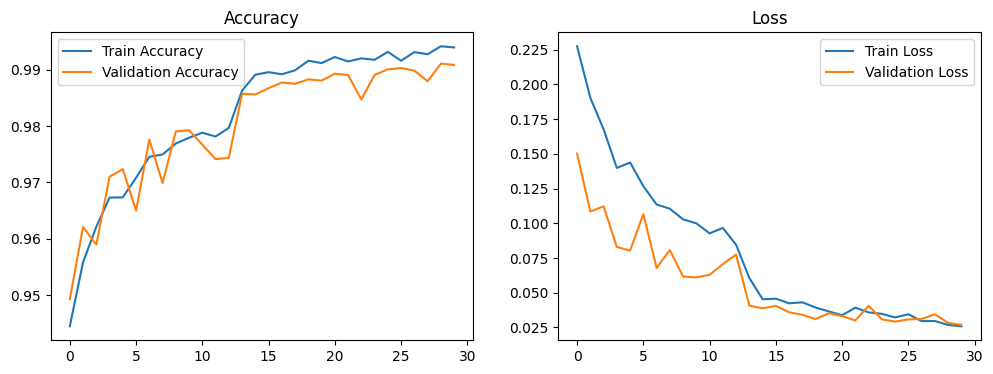

281/281 ━━━━━━━━━━━━━━━━━━━━ 174s 615ms/step - accuracy: 0.9910 - loss: 0.0309
Test Accuracy: 0.9909, Test Loss: 0.0268
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

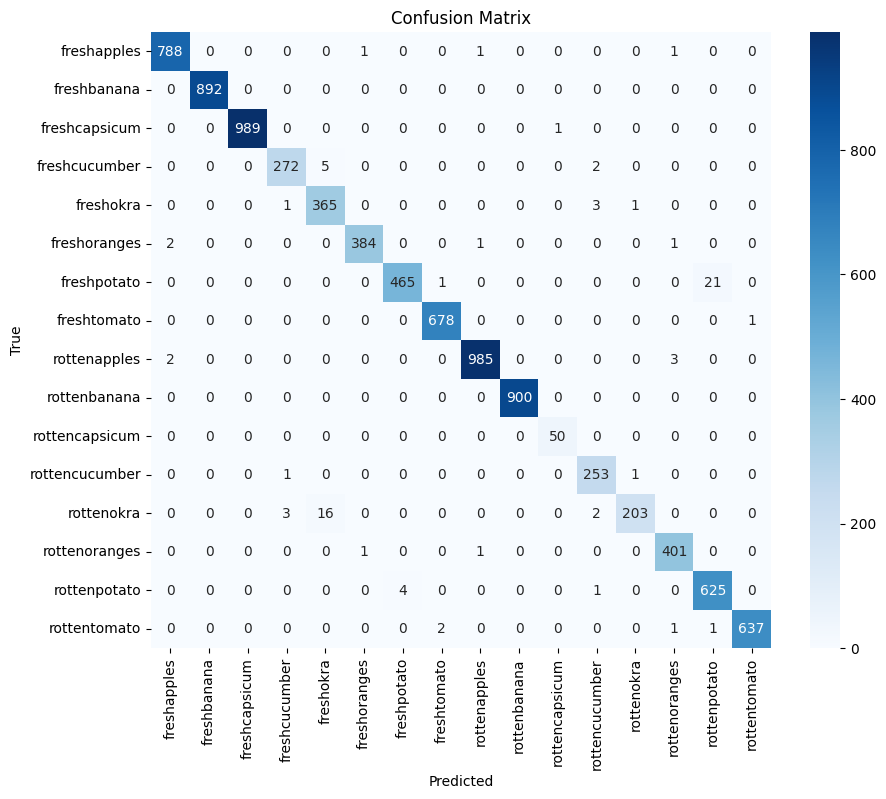

                precision    recall  f1-score   support

   freshapples       0.99      1.00      1.00       791
   freshbanana       1.00      1.00      1.00       892
 freshcapsicum       1.00      1.00      1.00       990
 freshcucumber       0.98      0.97      0.98       279
     freshokra       0.95      0.99      0.97       370
  freshoranges       0.99      0.99      0.99       388
   freshpotato       0.99      0.95      0.97       487
   freshtomato       1.00      1.00      1.00       679
  rottenapples       1.00      0.99      1.00       990
  rottenbanana       1.00      1.00      1.00       900
rottencapsicum       0.98      1.00      0.99        50
rottencucumber       0.97      0.99      0.98       255
    rottenokra       0.99      0.91      0.95       224
 rottenoranges       0.99      1.00      0.99       403
  rottenpotato       0.97      0.99      0.98       630
  rottentomato       1.00      0.99      1.00       641

      accuracy                           0.99 

Saving half-of-rotten-potato-isolated-on-white-background-2T36DJF.jpg to half-of-rotten-potato-isolated-on-white-background-2T36DJF.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction Probabilities: [9.2159066e-19 6.1313565e-16 5.2173961e-21 1.9465768e-18 9.9317127e-20
 2.4536816e-19 8.0766498e-11 2.3106807e-12 1.6897583e-10 3.0586510e-12
 4.3975312e-20 3.5177392e-09 1.4855462e-17 8.6695276e-05 9.9991333e-01
 2.8925219e-12]
Predicted Class: rottenpotato (Confidence: 0.9999)


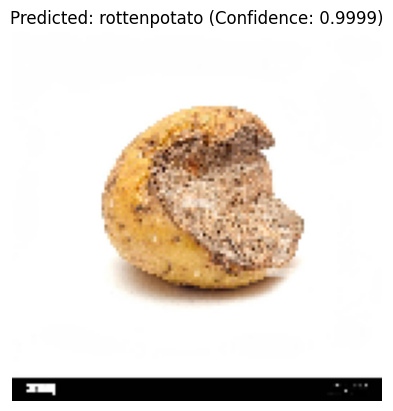

In [ ]:
# [CHANGE POINT 6: Add Training Visualization]
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

# Generate and plot confusion matrix
y_pred = []
y_true = []
for images, labels in test_data:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels, axis=1))
    if len(y_true) >= test_data.samples:
        break

with open('/content/drive/MyDrive/SmartSortingApp/models/class_indices.json', 'r') as f:
    class_indices = json.load(f)
index_to_class = {v: k for k, v in class_indices.items()}

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=index_to_class.values(), yticklabels=index_to_class.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print(classification_report(y_true, y_pred, target_names=index_to_class.values()))

# Save the trained model
model.save('/content/drive/MyDrive/SmartSortingApp/models/fruit_classifier.h5')

# Prediction on a new image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from google.colab import files

model = load_model('/content/drive/MyDrive/SmartSortingApp/models/fruit_classifier.h5')
with open('/content/drive/MyDrive/SmartSortingApp/models/class_indices.json', 'r') as f:
    class_indices = json.load(f)
index_to_class = {v: k for k, v in class_indices.items()}

uploaded = files.upload()
img_path = list(uploaded.keys())[0]
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction[0])
predicted_class_name = index_to_class[predicted_class_index]
print("Prediction Probabilities:", prediction[0])
print("Predicted Class:", predicted_class_name, f"(Confidence: {prediction[0][predicted_class_index]:.4f})")

plt.imshow(img)
plt.title(f"Predicted: {predicted_class_name} (Confidence: {prediction[0][predicted_class_index]:.4f})")
plt.axis('off')
plt.show()